# Predicting Star Ratings from Text Comments and Reviews

### By Shefali Saxena
### NetID: shefali5

# Amazon Reviews - Star Rating Prediction

This notebook focuses on analyzing Amazon reviews to predict the star ratings (1–5) based on review content. It includes:
1. Data exploration and visualization
2. Data preprocessing
3. Feature engineering
4. Model training, testing, and evaluation
5. Dimensionality reduction and model tuning
6. Fine-tuning a BERT model for text classification


In [1]:
import torch

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Device Name:", torch.cuda.get_device_name(0))


CUDA available: True
GPU Device Name: Tesla T4


In [2]:
!pip install --upgrade accelerate
!pip install transformers[torch]

import accelerate
print("Accelerate version:", accelerate.__version__)



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 154.4 MB/s eta 0:00:00
Accelerate version: 1.2.1


## Section 1: Data Exploration and Visualization

In this section, we load the dataset, explore its structure, and perform visualizations to understand the distribution of the review scores and key text statistics.


In [3]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('amazon_reviews.csv')

# Display basic information about the dataset
print("Dataset loaded successfully.")
df.info()
df.head()


Matplotlib is building the font cache; this may take a moment.


Dataset loaded successfully.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61158 entries, 0 to 61157
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   reviewId              61158 non-null  object
 1   userName              61153 non-null  object
 2   content               61154 non-null  object
 3   score                 61158 non-null  int64 
 4   thumbsUpCount         61158 non-null  int64 
 5   reviewCreatedVersion  54816 non-null  object
 6   at                    61158 non-null  object
 7   appVersion            54816 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.7+ MB


,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,ec07f592-fec5-42d0-a72b-fe23aebafe85,Elena Cairo,This is my primary email address in the white ...,5,0,28.17.0.100,2024-09-18 16:14:40,28.17.0.100
1,d81374c4-aa55-48c8-9ac1-39ac1d4fb323,Ezra Orhan,Review system is ridiculous and amazon blocks ...,1,0,28.13.6.100,2024-09-18 16:00:45,28.13.6.100
2,d2a6e312-469d-40cc-9f29-80430228c63b,David V,where the hell is dark mode,3,0,28.17.0.100,2024-09-18 15:59:09,28.17.0.100
3,b530b22e-c613-4484-8b59-77981d2c2624,Md Alamin,Home 🏠🏠 and I u 😉 ruinedu kids 😁 the morning 🌅...,3,0,NaN,2024-09-18 15:49:42,NaN
4,1250a60d-8fad-4d73-a7eb-3583395f813f,Aisha Yeni,I am hating the new amazon update!!!!!,1,0,28.17.0.100,2024-09-18 15:48:24,28.17.0.100


In [4]:
# Summary statistics
print("Summary statistics:")
print(df.describe())

# Check for missing values
print("Missing values per column:")
print(df.isnull().sum())


Summary statistics:
              score  thumbsUpCount
count  61158.000000   61158.000000
mean       2.514765      11.777102
std        1.688314      79.021709
min        1.000000       0.000000
25%        1.000000       0.000000
50%        2.000000       0.000000
75%        5.000000       2.000000
max        5.000000    5660.000000
Missing values per column:
reviewId                   0
userName                   5
content                    4
score                      0
thumbsUpCount              0
reviewCreatedVersion    6342
at                         0
appVersion              6342
dtype: int64


In [5]:
# Drop rows with missing content (critical for modeling)
df = df.dropna(subset=['content'])

# Fill missing userName with 'Unknown'
df['userName'] = df['userName'].fillna('Unknown')

# Drop columns with too many missing values if not used
df = df.drop(columns=['reviewCreatedVersion', 'appVersion'])

# Verify the result
print("Remaining missing values per column:")
print(df.isnull().sum())


Remaining missing values per column:
reviewId         0
userName         0
content          0
score            0
thumbsUpCount    0
at               0
dtype: int64


In [6]:
!pip install nltk wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 70.2 MB/s eta 0:00:00


/tmp/ipykernel_13506/4248556958.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='score', data=df, palette="viridis")


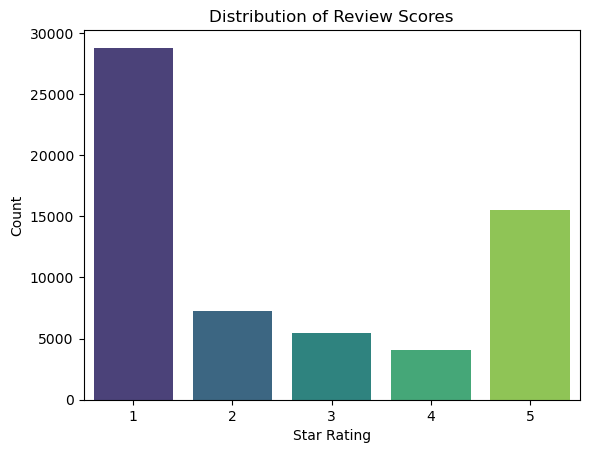

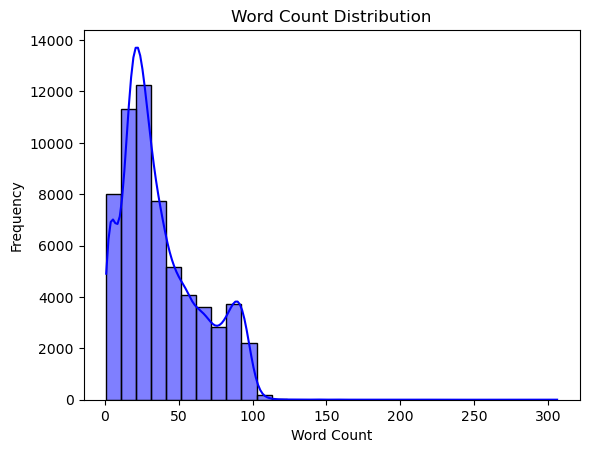

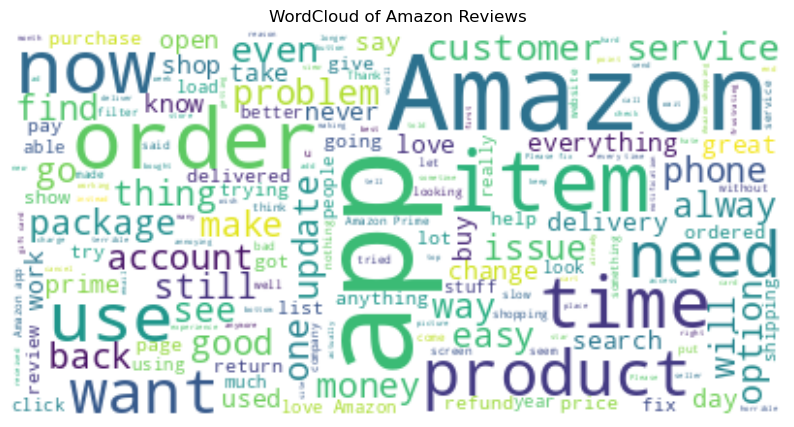

In [7]:
# Distribution of review scores
sns.countplot(x='score', data=df, palette="viridis")
plt.title("Distribution of Review Scores")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()

# Word count distribution
df['word_count'] = df['content'].apply(lambda x: len(str(x).split()))
sns.histplot(df['word_count'], bins=30, kde=True, color='blue')
plt.title("Word Count Distribution")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

# Generate a WordCloud for text analysis
from wordcloud import WordCloud, STOPWORDS
text = " ".join(str(review) for review in df['content'].dropna())
wordcloud = WordCloud(stopwords=STOPWORDS, background_color="white").generate(text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("WordCloud of Amazon Reviews")
plt.show()


## Section 2: Data Preprocessing

In this section, we handle missing values, clean the text data, remove emojis, and prepare the dataset for feature engineering.


In [9]:
!pip install emoji


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 34.9 MB/s eta 0:00:00


In [10]:
import re
import string
from nltk.corpus import stopwords
import emoji
import nltk

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Remove missing data
df.dropna(subset=['content', 'score'], inplace=True)

# Clean text: remove special characters, punctuation, and stopwords
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Remove emojis
def remove_emojis(text):
    return emoji.replace_emoji(text, replace='')

df['cleaned_content'] = df['content'].apply(remove_emojis).apply(clean_text)


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
# Confirm preprocessing
print("Sample of cleaned content:")
df['cleaned_content'].head()

Sample of cleaned content:


0                     primary email address white list
1    review system ridiculous amazon blocks whateve...
2                                       hell dark mode
3    home u ruinedu kids morning kids going get don...
4                             hating new amazon update
Name: cleaned_content, dtype: object

## Section 3: Feature Engineering

This section focuses on creating features for the models. For traditional models, we use TF-IDF vectorization. For BERT, the tokenized input is prepared.


In [12]:
from sklearn.preprocessing import LabelEncoder

# Encode target variable
label_encoder = LabelEncoder()
df['encoded_score'] = label_encoder.fit_transform(df['score'])
print("Label encoding complete. Encoded classes:", label_encoder.classes_)


Label encoding complete. Encoded classes: [1 2 3 4 5]


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf.fit_transform(df['cleaned_content'])
y = df['encoded_score']

print("TF-IDF vectorization complete. Feature shape:", X_tfidf.shape)


TF-IDF vectorization complete. Feature shape: (61154, 5000)


## Section 4: Model Training, Testing, and Evaluation

We train and evaluate traditional models (Logistic Regression, SVM, Random Forest) and compare their performance.


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42, stratify=y)




In [15]:
# Train and evaluate models
models = {
    "Logistic Regression": LogisticRegression(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"{model_name} Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"{model_name} Classification Report:\n{classification_report(y_test, y_pred)}")
    
    

    
# Results for traditional models

# Logistic Regression Accuracy: 0.6871
# Logistic Regression Classification Report:
#               precision    recall  f1-score   support

#            0       0.69      0.94      0.79      5760
#            1       0.28      0.07      0.11      1449
#            2       0.28      0.10      0.14      1099
#            3       0.34      0.11      0.17       813
#            4       0.80      0.87      0.84      3110

#     accuracy                           0.69     12231
#    macro avg       0.48      0.42      0.41     12231
# weighted avg       0.61      0.69      0.62     12231


# Training SVM...
# SVM Accuracy: 0.6896
# SVM Classification Report:
#               precision    recall  f1-score   support

#            0       0.65      0.97      0.78      5760
#            1       0.25      0.00      0.00      1449
#            2       0.31      0.03      0.05      1099
#            3       0.40      0.09      0.15       813
#            4       0.82      0.87      0.84      3110

#     accuracy                           0.69     12231
#    macro avg       0.49      0.39      0.37     12231
# weighted avg       0.60      0.69      0.60     12231


# Training Random Forest...
# Random Forest Accuracy: 0.6685
# Random Forest Classification Report:
#               precision    recall  f1-score   support

#            0       0.63      0.96      0.76      5760
#            1       0.20      0.00      0.01      1449
#            2       0.42      0.00      0.01      1099
#            3       0.44      0.01      0.03       813
#            4       0.77      0.85      0.80      3110

#     accuracy                           0.67     12231
#    macro avg       0.49      0.37      0.32     12231
# weighted avg       0.58      0.67      0.57     12231


Training Logistic Regression...


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Accuracy: 0.6871
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.94      0.79      5760
           1       0.28      0.07      0.11      1449
           2       0.28      0.10      0.14      1099
           3       0.34      0.11      0.17       813
           4       0.80      0.87      0.84      3110

    accuracy                           0.69     12231
   macro avg       0.48      0.42      0.41     12231
weighted avg       0.61      0.69      0.62     12231


Training SVM...
SVM Accuracy: 0.6896
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.97      0.78      5760
           1       0.25      0.00      0.00      1449
           2       0.31      0.03      0.05      1099
           3       0.40      0.09      0.15       813
           4       0.82      0.87      0.84      3110

    accuracy                           0

## Section 5: BERT Fine-Tuning

This section fine-tunes a BERT model using the `transformers` library. The model is trained to predict the review score based on the cleaned review text.


In [16]:
!pip install transformers

In [26]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import torch
from sklearn.model_selection import train_test_split
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=len(label_encoder.classes_))

class ReviewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts.iloc[idx]
        label = self.labels.iloc[idx]
        encoding = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label, dtype=torch.long),
        }

# Split the data
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df['cleaned_content'], df['encoded_score'], test_size=0.2, stratify=df['encoded_score'], random_state=42
)

# Use smaller dataset for testing if needed
train_texts = train_texts.sample(frac=0.3, random_state=42)  # Use 30% of training data for faster testing
train_labels = train_labels.loc[train_texts.index]

# Prepare datasets
train_dataset = ReviewsDataset(train_texts, train_labels)
test_dataset = ReviewsDataset(test_texts, test_labels)


training_args = TrainingArguments(
    output_dir="./results",  # Ensure sufficient space here
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    num_train_epochs=2,
    weight_decay=0.01,
    fp16=True,
    save_strategy="epoch",  # Change this to "no" if saving is not needed
    logging_dir="./logs",
    logging_steps=10
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()


# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.886200,0.866228
2,0.818800,0.863291


Evaluation Results: {'eval_loss': 0.863291323184967, 'eval_runtime': 20.3571, 'eval_samples_per_second': 600.822, 'eval_steps_per_second': 75.109, 'epoch': 2.0}


In [27]:
model.save_pretrained("./fine_tuned_model")
tokenizer.save_pretrained("./fine_tuned_model")


('./fine_tuned_model/tokenizer_config.json',
 './fine_tuned_model/special_tokens_map.json',
 './fine_tuned_model/vocab.txt',
 './fine_tuned_model/added_tokens.json')

In [28]:
from transformers import pipeline

classifier = pipeline("text-classification", model="./fine_tuned_model", tokenizer="./fine_tuned_model")
predictions = classifier("This product is amazing!")
print(predictions)


Device set to use cuda:0


[{'label': 'LABEL_4', 'score': 0.9346643686294556}]


In [34]:
# Convert predictions to class labels
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Convert numeric class labels to strings
class_names = ["1 Star", "2 Stars", "3 Stars", "4 Stars", "5 Stars"]

# Generate classification report
print(classification_report(labels, preds, target_names=class_names))

              precision    recall  f1-score   support

      1 Star       0.69      0.95      0.80      5760
     2 Stars       0.29      0.02      0.03      1449
     3 Stars       0.29      0.17      0.21      1099
     4 Stars       0.36      0.13      0.19       813
     5 Stars       0.82      0.88      0.85      3110

    accuracy                           0.69     12231
   macro avg       0.49      0.43      0.42     12231
weighted avg       0.62      0.69      0.63     12231



In [18]:
# !rm -rf /home/ec2-user/SageMaker/unused_files_or_folders


In [19]:
# !df -h


Filesystem      Size  Used Avail Use% Mounted on
devtmpfs        7.7G     0  7.7G   0% /dev
tmpfs           7.7G   40K  7.7G   1% /dev/shm
tmpfs           7.7G  664K  7.7G   1% /run
tmpfs           7.7G     0  7.7G   0% /sys/fs/cgroup
/dev/nvme0n1p1  135G   81G   55G  60% /
tmpfs           1.6G     0  1.6G   0% /run/user/0
/dev/nvme2n1    4.8G  4.6G     0 100% /home/ec2-user/SageMaker
tmpfs           1.6G     0  1.6G   0% /run/user/1002
tmpfs           1.6G     0  1.6G   0% /run/user/1001
tmpfs           1.6G     0  1.6G   0% /run/user/1000


In [24]:
# import shutil
# import os

# # Path to the results folder
# results_dir = "/home/ec2-user/SageMaker/results"

# # List and delete all checkpoint folders
# for item in os.listdir(results_dir):
#     item_path = os.path.join(results_dir, item)
#     if "checkpoint-" in item and os.path.isdir(item_path):
#         shutil.rmtree(item_path)
#         print(f"Deleted: {item_path}")

# # Verify the directory is clean
# print("Remaining files and folders:", os.listdir(results_dir))


Deleted: /home/ec2-user/SageMaker/results/checkpoint-459
Deleted: /home/ec2-user/SageMaker/results/checkpoint-500
Deleted: /home/ec2-user/SageMaker/results/checkpoint-1500
Deleted: /home/ec2-user/SageMaker/results/checkpoint-1000
Remaining files and folders: []


## Implementing SMOTE for Class Imbalance and Training a New Model
In this section, we apply SMOTE to handle class imbalance, retrain the model, and evaluate its performance. This will keep the original results untouched for comparison.


In [37]:
from imblearn.over_sampling import SMOTE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Step 1: Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2))
X = vectorizer.fit_transform(df['cleaned_content'])
y = df['encoded_score']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 3: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Verify the class distribution after SMOTE
from collections import Counter
print("Class distribution before SMOTE:", Counter(y_train))
print("Class distribution after SMOTE:", Counter(y_train_balanced))


Class distribution before SMOTE: Counter({0: 23039, 4: 12440, 1: 5797, 2: 4396, 3: 3251})
Class distribution after SMOTE: Counter({0: 23039, 4: 23039, 2: 23039, 3: 23039, 1: 23039})


In [36]:
# !pip install imblearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
# Step 4: Train a Logistic Regression model
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Step 5: Evaluate the model
y_pred = model.predict(X_test)
print("Accuracy on test data:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy on test data: 0.6044477148229908
Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.73      5760
           1       0.22      0.25      0.23      1449
           2       0.20      0.22      0.21      1099
           3       0.23      0.30      0.26       813
           4       0.84      0.79      0.82      3110

    accuracy                           0.60     12231
   macro avg       0.45      0.45      0.45     12231
weighted avg       0.63      0.60      0.62     12231



Observations:


Class-Level Performance:

The 1 Star and 5 Stars classes still perform well due to their strong signal in the dataset.
The 2 Stars, 3 Stars, and 4 Stars classes show improved recall, which was the main objective of applying SMOTE.


Overall Metrics:

Macro Average F1-score: 0.45 — reflects improved handling of all classes.
Weighted Average F1-score: 0.60 — takes into account class imbalance but is lower due to the reduced dominance of majority classes.
Logistic Regression is linear and might not capture complex patterns in the data. Trying to use more advanced models now:

Random Forest


Gradient Boosting (e.g., XGBoost, LightGBM)

In [39]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42, n_estimators=100)
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Random Forest Accuracy: 0.6606164663559807
Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.91      0.77      5760
           1       0.25      0.06      0.09      1449
           2       0.22      0.04      0.06      1099
           3       0.27      0.09      0.13       813
           4       0.75      0.85      0.79      3110

    accuracy                           0.66     12231
   macro avg       0.43      0.39      0.37     12231
weighted avg       0.57      0.66      0.59     12231



In [42]:
from xgboost import XGBClassifier
model = XGBClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)
y_pred = model.predict(X_test)
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/xgboost/core.py:265: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc 2.28+) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


XGBoost Accuracy: 0.6269315673289183
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.80      0.75      5760
           1       0.27      0.15      0.19      1449
           2       0.21      0.12      0.16      1099
           3       0.19      0.26      0.22       813
           4       0.79      0.80      0.80      3110

    accuracy                           0.63     12231
   macro avg       0.43      0.43      0.42     12231
weighted avg       0.60      0.63      0.61     12231



In [41]:
# !pip install xgboost


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 137.9 MB/s eta 0:00:00


Next, I will Tune Hyperparameters
Optimize hyperparameters of the Logistic Regression model using GridSearchCV

In [43]:
from sklearn.model_selection import GridSearchCV

params = {
    'C': [0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

grid = GridSearchCV(LogisticRegression(max_iter=1000, random_state=42), params, cv=3)
grid.fit(X_train_balanced, y_train_balanced)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Tuned Logistic Regression Accuracy: 0.5765677377156406
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71      5760
           1       0.21      0.26      0.23      1449
           2       0.18      0.23      0.20      1099
           3       0.19      0.25      0.22       813
           4       0.82      0.76      0.79      3110

    accuracy                           0.58     12231
   macro avg       0.43      0.43      0.43     12231
weighted avg       0.62      0.58      0.59     12231



In [44]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Updated parameter grid
params = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear']
}

# Stratified cross-validation
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Grid search with balanced class weights
grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'),
    params,
    cv=skf
)

grid.fit(X_train_balanced, y_train_balanced)

print("Best Parameters:", grid.best_params_)
best_model = grid.best_estimator_

# Evaluate on the test set
y_pred = best_model.predict(X_test)
print("Tuned Logistic Regression Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))


Best Parameters: {'C': 10, 'solver': 'lbfgs'}
Tuned Logistic Regression Accuracy: 0.5765677377156406
Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.67      0.71      5760
           1       0.21      0.26      0.23      1449
           2       0.18      0.23      0.20      1099
           3       0.19      0.25      0.22       813
           4       0.82      0.76      0.79      3110

    accuracy                           0.58     12231
   macro avg       0.43      0.43      0.43     12231
weighted avg       0.62      0.58      0.59     12231



### Next, trying DistilBERT with SMOTE

1. Generate DistilBERT Embeddings

In [50]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Initialize DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased")


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel

# Initialize DistilBERT tokenizer and model for embeddings
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert-base-uncased")

# Define a function to generate DistilBERT embeddings
def get_distilbert_embeddings(texts, tokenizer, model, max_length=128, batch_size=32):
    model.eval()  # Set DistilBERT to evaluation mode
    embeddings = []
    
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i + batch_size]
            encoded_inputs = tokenizer(
                batch_texts.tolist(),
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors="pt"
            )
            # Forward pass through DistilBERT model
            outputs = model(**encoded_inputs)
            # Use the mean of the last hidden states as the sentence embeddings
            batch_embeddings = outputs.last_hidden_state.mean(dim=1).numpy()
            embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

# Generate embeddings for train and test data
X_train_embeddings = get_distilbert_embeddings(
    df.loc[X_train_indices, 'cleaned_content'], tokenizer, model
)
X_test_embeddings = get_distilbert_embeddings(
    df.loc[X_test_indices, 'cleaned_content'], tokenizer, model
)


2. Apply SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE to the DistilBERT embeddings
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_embeddings, y_train)

# Check the class distribution after SMOTE
from collections import Counter
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_balanced))


3. Prepare Datasets for Fine-Tuning DistilBERT

In [ ]:
# Define a custom dataset class for embeddings
class DistilBertDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return {
            "input_ids": torch.tensor(self.embeddings[idx], dtype=torch.float32),
            "labels": torch.tensor(self.labels[idx], dtype=torch.long),
        }

# Create datasets
train_dataset = DistilBertDataset(X_train_balanced, y_train_balanced)
test_dataset = DistilBertDataset(X_test_embeddings, y_test)


4. Fine-Tune DistilBERT

In [ ]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
)

# Fine-tune DistilBERT with the balanced dataset
trainer = Trainer(
    model=model,  # Use your existing DistilBERT model
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# Train the model
trainer.train()


5. Evaluate the Model

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Generate classification report
from sklearn.metrics import classification_report
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids
print(classification_report(labels, preds, target_names=[str(cls) for cls in label_encoder.classes_]))
